CFE Data Assimilation of USGS streamflow data. Synthetic Forcing Data example to test methodology and 1-18 hour forecast. 

In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta

sys.path.insert(0, './CFE')
#import bmi_cfe_originial
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI


(750.0, 780.0)

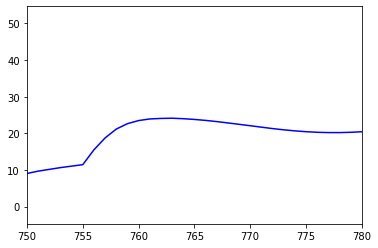

In [2]:
# Get Synthetic Observations (USGS)
cfe_obs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_obs.initialize(cfg_file='./CFE/config_cfe_synthetic.json')

# Open forcing file
with open(cfe_obs.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
# Make empty list to plot
OBSERVATIONS_LIST = []

# Loop through precipitation in forcing data to set values
for i, precip in enumerate(df_forcing['APCP_surface_0']): #i is RAINRATE
    cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
    cfe_obs.update()
    # Get streamflow based on sin wave to see variation in synthetic observed streamflow
    OBSERVATIONS_LIST.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)

cfe_obs.finalize()

# See plot to make sure it works
plt.plot(OBSERVATIONS_LIST,color = 'blue')
plt.xlim(750,780)

In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()

Final Framework for running each synthetic CFE model, EnKF DA, and synthetic observations

In [4]:
#Make empty matrices for plotting
cfeOpen_ensa    = []
cfeAnalysis_ens = []

## Loop through n different precipitation files for forcing. Max is 100 from forcing data
n_loop = 2
for loop in range(n_loop):
    p = 'APCP_surface_' + str(loop) #set p to each synthetic forcing data
    
    # Make empty matrices for plotting
    cfeOpen = []
    cfePeturbed = []
    cfeAnalysis = []
    cfeEnKF = []
    
    # Initialize Case study files
    cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json')
    
    ## Loop through time. Set values for each model and get values
    for i, precip in enumerate(df_forcing[str(p)]):

        # Set values for each CFE model. Adding precipitation since we are using an uncalibrated model to see flow result
        cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3) #value of precip from forcing data in loop
        cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
        cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
        
        # Update usgs data and get value to put into EnKF
        obs = OBSERVATIONS_LIST[i]
        enkf.set_value('validity', 1)

        # set observations to plot without EnKF for future forecast
        if i>=768:
            enkf.set_value('validity', 0)

        # Update CFE open and peturbed. Get value for peturbed stats. 
        cfe_open.update()
        cfe_peturbed.update()
        
        # Get state variable originial values from CFE Peturbed to update in EnKF
        soil_storage_avail             = cfe_peturbed.get_value('soil_storage_avail_m')
        soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
        storage_max_m                  = cfe_peturbed.get_value("storage_max_out_m")
        surface_runoff                 = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')

        # Set outflow for CFE Open and CFE Peturbed to plot
        outflow        = cfe_open.get_value('land_surface_water__runoff_depth')
        cfeOpen.append(outflow) #for plotting
        
        # Get mean and covariance of CFE Peturbed outflor of ensemble runs for EnKF
        outflow_peturb       = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
        outflow_peturb_mean  = np.mean(outflow_peturb)
        outflow_peturb_covar = np.cov(outflow_peturb)
        cfePeturbed.append(outflow_peturb_mean) # For plotting

        # Set EnKF state variable values to state variables from CFE Petubred
        enkf.set_value('soil_storage_avail_m', soil_storage_avail) 
        enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) 
        enkf.set_value('surface_runoff_depth_m', surface_runoff)
        enkf.set_value('storage_max_m',storage_max_m)

        # Set EnkF values usgs, mean, and covariance (from CFE Peturbed)
        enkf.set_value('x', np.array([outflow_peturb_mean]))
        enkf.set_value('P', np.array([outflow_peturb_covar]))
        enkf.set_value('z', np.array([obs]))
        #enkf_validity=enkf.set_value('validity',validity) #check validity if needed
        enkf.update()
        
        # For plotting if needed
        outflow_enkf = enkf.get_value('enkf')
        cfeEnKF.append(outflow_enkf)
        
        # Get updated state variable values from EnKF to pass into CFE Analysis
        state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
        state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
        # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
        state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

        # Set CFE analysis state variable changes from EnKF to get final true streamflow values
        cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) 
        cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) 
        cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
        cfe_analysis.update() #get new streamflow value based on state var change
        
        # For plotting CFE Analysis from newly updated state variables. FINAL MODEL! 
        outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
        cfeAnalysis.append(outflow_analysis) 

        # Get CFE Analysis state variables to then pass back into CFE Peturbed 
        cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
        cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
        cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

        # Set updated state variables into CFE Peturbed for the loop of updating state variables to continue! 
        cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
        cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
        cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)

    # Append models results from last hour of data assimilation for the 18 hour forecast
    cfeOpen_ensa.append(np.divide(abs(np.subtract(cfeOpen[767:],OBSERVATIONS_LIST[767:])),OBSERVATIONS_LIST[767:]))
    cfeAnalysis_ens.append(np.divide(abs(np.subtract(cfeAnalysis[767:],OBSERVATIONS_LIST[767:])),OBSERVATIONS_LIST[767:]))
    
    # Get mean of each hour in 18hour forecast
    cfeOpen_ensa_mean=np.mean(cfeOpen_ensa,axis=0)
    cfeanalysis_ensa_mean=np.mean(cfeAnalysis_ens,axis=0)
    
# Finalize the models!  
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
enkf.finalize()


initialized 10
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3121136221931379
EnKF Code predicted, X Post [9.77704091]
surface_runoff_ratio [2.16166509]
Leftover vol 0.0
surface _runoff [2.16166509]
***********over estimaiton ratio [1.]
Observation BMI [9.14803171]
CFE [22.08335826]
enkf [9.77704091]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2957114578598735
EnKF Code predicted, X Post [17.22834696]
surface_runoff_ratio [1.25114759]
Leftover vol [35.98961104]
surface _runoff [1.25114759]
***********over estimaiton ratio [0.32373183]
Observation BMI [16.75252741]
CFE [53.21795801]
enkf [17.22834696]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28072802840953426
EnKF Code predicted, X Post [22.83435914]
surface_runoff_ratio [1.59789191]
Leftover vol [29.29010856]
surface _runoff [1.59789191]
***********over estimaiton ratio [0.43807371]
Observation BMI [22.40183725]
CFE [52.12446

Leftover vol 0.0
surface _runoff [0.26886367]
***********over estimaiton ratio [1.]
Observation BMI [2.92985482]
CFE [3.46548707]
enkf [2.91206708]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16074573073185794
EnKF Code predicted, X Post [2.00967253]
***********under estimaiton ratio [1.19869656]
Observation BMI [2.19477017]
CFE [1.67654819]
enkf [2.00967253]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16874301094255306
EnKF Code predicted, X Post [0.69644389]
surface_runoff_ratio [0.07293573]
Leftover vol 0.0
surface _runoff [0.07293573]
***********over estimaiton ratio [1.]
Observation BMI [1.6166818]
CFE [0.94122818]
enkf [0.69644389]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17661029940438366
EnKF Code predicted, X Post [0.10946981]
surface_runoff_ratio [0.03375653]
Leftover vol 0.0
surface _runoff [0.03375653]
***********over estimaiton ratio [1.]
Observation BMI [1.124

Observation BMI [-0.23189355]
CFE [0.01489404]
enkf [-0.16735216]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.30382393383863526
EnKF Code predicted, X Post [-0.15834367]
surface_runoff_ratio [0.00148033]
Leftover vol 0.0
surface _runoff [0.00148033]
***********over estimaiton ratio [1.]
Observation BMI [-0.62109308]
CFE [0.01844837]
enkf [-0.15834367]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3094955501540775
EnKF Code predicted, X Post [2.12669596]
surface_runoff_ratio [0.64882919]
Leftover vol 0.0
surface _runoff [0.64882919]
***********over estimaiton ratio [1.]
Observation BMI [1.74505054]
CFE [7.3518469]
enkf [2.12669596]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.29335718979398595
EnKF Code predicted, X Post [4.62913192]
surface_runoff_ratio [1.15894453]
Leftover vol 0.0
surface _runoff [1.15894453]
***********over estimaiton ratio [1.]
Observation BMI [3.57318577]
CF

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2132375577172302
EnKF Code predicted, X Post [12.90291298]
surface_runoff_ratio [1.65389937]
Leftover vol 0.0
surface _runoff [1.65389937]
***********over estimaiton ratio [1.]
Observation BMI [12.57588391]
CFE [18.0533011]
enkf [12.90291298]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.20540063768718542
EnKF Code predicted, X Post [13.67591722]
surface_runoff_ratio [0.9085028]
Leftover vol [16.34763242]
surface _runoff [0.9085028]
***********over estimaiton ratio [0.45550634]
Observation BMI [12.28295889]
CFE [30.02354964]
enkf [13.67591722]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19824101139103656
EnKF Code predicted, X Post [12.25653989]
surface_runoff_ratio [1.75724948]
Leftover vol 0.0
surface _runoff [1.75724948]
***********over estimaiton ratio [1.]
Observation BMI [11.94222125]
CFE [26.94611149]
enkf [12.25653989]
Beginnin

EnKF Code predicted, X Post [0.93818817]
surface_runoff_ratio [0.13358706]
Leftover vol 0.0
surface _runoff [0.13358706]
***********over estimaiton ratio [1.]
Observation BMI [0.32957033]
CFE [1.64205024]
enkf [0.93818817]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18391882634825008
EnKF Code predicted, X Post [0.13440069]
surface_runoff_ratio [0.05276019]
Leftover vol 0.0
surface _runoff [0.05276019]
***********over estimaiton ratio [1.]
Observation BMI [-0.46852133]
CFE [0.68404863]
enkf [0.13440069]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19153943959887676
EnKF Code predicted, X Post [-0.62031756]
surface_runoff_ratio [0.03433341]
Leftover vol 0.0
surface _runoff [0.03433341]
***********over estimaiton ratio [1.]
Observation BMI [-0.95889117]
CFE [0.48241693]
enkf [-0.62031756]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19903618363174813
EnKF Code predicted, X Post [-

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.29203950011622737
EnKF Code predicted, X Post [-0.32604654]
surface_runoff_ratio [0.00158587]
Leftover vol 0.0
surface _runoff [0.00158587]
***********over estimaiton ratio [1.]
Observation BMI [-1.15256504]
CFE [0.02193873]
enkf [-0.32604654]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.29790266644724905
EnKF Code predicted, X Post [0.37211636]
***********under estimaiton ratio [15.9432754]
Observation BMI [-1.45107419]
CFE [0.02334002]
enkf [0.37211636]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.30367052997217014
EnKF Code predicted, X Post [-0.24343779]
surface_runoff_ratio [0.00158246]
Leftover vol 0.0
surface _runoff [0.00158246]
***********over estimaiton ratio [1.]
Observation BMI [-1.69093414]
CFE [0.01609134]
enkf [-0.24343779]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.309344639789948
E

soil_storage_deficit_from CFE 0.17061607640968923
EnKF Code predicted, X Post [20.70904309]
surface_runoff_ratio [1.46435115]
Leftover vol [27.0021844]
surface _runoff [1.46435115]
***********over estimaiton ratio [0.43404968]
Observation BMI [20.30247424]
CFE [47.71122749]
enkf [20.70904309]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16645717976616492
EnKF Code predicted, X Post [19.93561233]
surface_runoff_ratio [3.09422925]
Leftover vol 0.0
surface _runoff [3.09422925]
***********over estimaiton ratio [1.]
Observation BMI [20.21994755]
CFE [28.33229844]
enkf [19.93561233]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16265814421204572
EnKF Code predicted, X Post [21.74182711]
surface_runoff_ratio [1.47255401]
Leftover vol [34.71628219]
surface _runoff [1.47255401]
***********over estimaiton ratio [0.38509662]
Observation BMI [20.21658733]
CFE [56.4581093]
enkf [21.74182711]
Beginning----------------------------

***********over estimaiton ratio [1.]
Observation BMI [-1.65391079]
CFE [0.6243674]
enkf [-0.58017355]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19898617454657597
EnKF Code predicted, X Post [-0.52111226]
surface_runoff_ratio [0.00158674]
Leftover vol 0.0
surface _runoff [0.00158674]
***********over estimaiton ratio [1.]
Observation BMI [-1.9739119]
CFE [0.02623204]
enkf [-0.52111226]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2063618756656469
EnKF Code predicted, X Post [-0.09999843]
surface_runoff_ratio [0.0015879]
Leftover vol 0.0
surface _runoff [0.0015879]
***********over estimaiton ratio [1.]
Observation BMI [-1.96470665]
CFE [0.0192758]
enkf [-0.09999843]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.21361768848990892
EnKF Code predicted, X Post [-0.79639573]
surface_runoff_ratio [0.00158892]
Leftover vol 0.0
surface _runoff [0.00158892]
***********over estimaiton rati

surface_runoff_ratio [3.76101883]
Leftover vol [59.92448707]
surface _runoff [3.76101883]
***********over estimaiton ratio [0.4514166]
Observation BMI [48.9795298]
CFE [109.23496282]
enkf [49.31047575]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.15378552615447627
EnKF Code predicted, X Post [32.53523534]
surface_runoff_ratio [1.90025986]
Leftover vol [66.11456349]
surface _runoff [1.90025986]
***********over estimaiton ratio [0.32980539]
Observation BMI [32.16703035]
CFE [98.64979883]
enkf [32.53523534]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16189594097364224
EnKF Code predicted, X Post [19.21521196]
surface_runoff_ratio [1.7723253]
Leftover vol [20.73708338]
surface _runoff [1.7723253]
***********over estimaiton ratio [0.48095389]
Observation BMI [18.90517812]
CFE [39.95229535]
enkf [19.21521196]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.169874525098049
EnKF Code predi

***********under estimaiton ratio [5.82049055]
Observation BMI [-0.30438937]
CFE [0.01209642]
enkf [0.07040711]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4691307940379241
EnKF Code predicted, X Post [-0.17040038]
surface_runoff_ratio [0.00127949]
Leftover vol 0.0
surface _runoff [0.00127949]
***********over estimaiton ratio [1.]
Observation BMI [-0.69029198]
CFE [0.01692531]
enkf [-0.17040038]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4721154308690334
EnKF Code predicted, X Post [-0.40716612]
surface_runoff_ratio [0.00127145]
Leftover vol 0.0
surface _runoff [0.00127145]
***********over estimaiton ratio [1.]
Observation BMI [-1.04802791]
CFE [0.01335472]
enkf [-0.40716612]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4750515539365656
EnKF Code predicted, X Post [-0.64306463]
surface_runoff_ratio [0.0012633]
Leftover vol 0.0
surface _runoff [0.0012633]
***********over estima

***********over estimaiton ratio [1.]
Observation BMI [2.55461398]
CFE [6.5041053]
enkf [3.05613385]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18840810064634184
EnKF Code predicted, X Post [0.94022757]
surface_runoff_ratio [0.26177258]
Leftover vol 0.0
surface _runoff [0.26177258]
***********over estimaiton ratio [1.]
Observation BMI [0.41835614]
CFE [3.53519271]
enkf [0.94022757]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19595574301164664
EnKF Code predicted, X Post [0.56665811]
surface_runoff_ratio [0.12201972]
Leftover vol 0.0
surface _runoff [0.12201972]
***********over estimaiton ratio [1.]
Observation BMI [-0.82940173]
CFE [1.74371432]
enkf [0.56665811]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.20338070226406557
EnKF Code predicted, X Post [-0.5959678]
surface_runoff_ratio [0.05462769]
Leftover vol 0.0
surface _runoff [0.05462769]
***********over estimaiton ratio [

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5003918480803748
EnKF Code predicted, X Post [-0.83496532]
surface_runoff_ratio [0.00114244]
Leftover vol 0.0
surface _runoff [0.00114244]
***********over estimaiton ratio [1.]
Observation BMI [-1.91952833]
CFE [0.01547852]
enkf [-0.83496532]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5028683522739794
EnKF Code predicted, X Post [-1.23101134]
surface_runoff_ratio [0.0011344]
Leftover vol 0.0
surface _runoff [0.0011344]
***********over estimaiton ratio [1.]
Observation BMI [-1.77987744]
CFE [0.01322229]
enkf [-1.23101134]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5053046021432743
EnKF Code predicted, X Post [-1.03102782]
surface_runoff_ratio [0.00112628]
Leftover vol 0.0
surface _runoff [0.00112628]
***********over estimaiton ratio [1.]
Observation BMI [-1.56869493]
CFE [0.01473602]
enkf [-1.03102782]
Beginning---------------------

EnKF Code predicted, X Post [23.47689189]
surface_runoff_ratio [3.52955622]
Leftover vol 0.0
surface _runoff [3.52955622]
***********over estimaiton ratio [1.]
Observation BMI [23.53777312]
CFE [33.8806735]
enkf [23.47689189]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18800844474291933
EnKF Code predicted, X Post [23.3855061]
surface_runoff_ratio [2.00263977]
Leftover vol [25.72387705]
surface _runoff [2.00263977]
***********over estimaiton ratio [0.47619222]
Observation BMI [23.21848559]
CFE [49.10938315]
enkf [23.3855061]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18234469935075237
EnKF Code predicted, X Post [22.90385205]
 warning validity is zero
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17717098718753344
EnKF Code predicted, X Post [23.12738847]
 warning validity is zero
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17244492179339888

EnKF Code predicted, X Post [1.95376179]
surface_runoff_ratio [0.12183765]
Leftover vol [24.66428352]
surface _runoff [0.12183765]
***********over estimaiton ratio [0.0733999]
Observation BMI [1.03358117]
CFE [26.61804531]
enkf [1.95376179]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12434108724782267
EnKF Code predicted, X Post [6.99324908]
surface_runoff_ratio [0.52524983]
Leftover vol [10.63413031]
surface _runoff [0.52524983]
***********over estimaiton ratio [0.39672653]
Observation BMI [0.94317247]
CFE [17.62737939]
enkf [6.99324908]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12419008145225074
EnKF Code predicted, X Post [1.00209069]
surface_runoff_ratio [0.08602174]
Leftover vol [13.53145024]
surface _runoff [0.08602174]
***********over estimaiton ratio [0.06895021]
Observation BMI [0.83723314]
CFE [14.53354093]
enkf [1.00209069]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CF

***********over estimaiton ratio [1.]
Observation BMI [6.95295093]
CFE [13.44441711]
enkf [8.77519186]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12287237266182971
EnKF Code predicted, X Post [6.59801243]
surface_runoff_ratio [0.46406355]
Leftover vol [27.49697087]
surface _runoff [0.46406355]
***********over estimaiton ratio [0.19351857]
Observation BMI [6.64680704]
CFE [34.0949833]
enkf [6.59801243]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12284521208379973
EnKF Code predicted, X Post [6.96921509]
surface_runoff_ratio [0.83590579]
Leftover vol [9.84312815]
surface _runoff [0.83590579]
***********over estimaiton ratio [0.41452967]
Observation BMI [6.29610098]
CFE [16.81234324]
enkf [6.96921509]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12282093221901558
EnKF Code predicted, X Post [6.24125517]
surface_runoff_ratio [0.58777426]
Leftover vol [15.16358879]
surface _runoff 

EnKF Code predicted, X Post [10.19460048]
surface_runoff_ratio [1.99996714]
Leftover vol 0.0
surface _runoff [1.99996714]
***********over estimaiton ratio [1.]
Observation BMI [9.73117217]
CFE [16.55312299]
enkf [10.19460048]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12259325134698462
EnKF Code predicted, X Post [9.67924236]
surface_runoff_ratio [0.76128963]
Leftover vol [24.80258472]
surface _runoff [0.76128963]
***********over estimaiton ratio [0.28070561]
Observation BMI [9.98517707]
CFE [34.48182708]
enkf [9.67924236]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12259114435417628
EnKF Code predicted, X Post [11.0804206]
surface_runoff_ratio [0.89930384]
Leftover vol [18.19662572]
surface _runoff [0.89930384]
***********over estimaiton ratio [0.37846784]
Observation BMI [10.17271647]
CFE [29.27704631]
enkf [11.0804206]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1225879943

***********over estimaiton ratio [1.]
Observation BMI [1.72182081]
CFE [10.85211404]
enkf [2.48237306]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12273751481335149
EnKF Code predicted, X Post [2.44198852]
surface_runoff_ratio [0.2080578]
Leftover vol [13.59099604]
surface _runoff [0.2080578]
***********over estimaiton ratio [0.15231029]
Observation BMI [1.89664409]
CFE [16.03298456]
enkf [2.44198852]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12272473445525134
EnKF Code predicted, X Post [3.59167655]
surface_runoff_ratio [0.2608251]
Leftover vol [12.33187685]
surface _runoff [0.2608251]
***********over estimaiton ratio [0.22555748]
Observation BMI [1.99665049]
CFE [15.9235534]
enkf [3.59167655]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1227113830258787
EnKF Code predicted, X Post [3.20498762]
surface_runoff_ratio [0.95863457]
Leftover vol 0.0
surface _runoff [0.95863457]
*

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12270072627579642
EnKF Code predicted, X Post [-0.92435031]
surface_runoff_ratio [-0.08500806]
Leftover vol [18.42840731]
surface _runoff [-0.08500806]
***********over estimaiton ratio [-0.05280778]
Observation BMI [-1.3411508]
CFE [17.50405701]
enkf [-0.92435031]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12268966242249946
EnKF Code predicted, X Post [-1.16432445]
surface_runoff_ratio [-0.09523071]
Leftover vol [15.54755177]
surface _runoff [-0.09523071]
***********over estimaiton ratio [-0.08095015]
Observation BMI [-1.02292809]
CFE [14.38322732]
enkf [-1.16432445]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12268087816915496
EnKF Code predicted, X Post [0.27123021]
surface_runoff_ratio [0.01660951]
Leftover vol [12.20855586]
surface _runoff [0.01660951]
***********over estimaiton ratio [0.02173356]
Observation BMI [-0.66312295]
C

EnKF Code predicted, X Post [-0.59938953]
surface_runoff_ratio [0.55410172]
Leftover vol 0.0
surface _runoff [0.55410172]
***********over estimaiton ratio [1.]
Observation BMI [-0.80730648]
CFE [8.01784022]
enkf [-0.59938953]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12270369010520554
EnKF Code predicted, X Post [-0.6331249]
surface_runoff_ratio [-0.05894164]
Leftover vol [17.88908478]
surface _runoff [-0.05894164]
***********over estimaiton ratio [-0.03669022]
Observation BMI [-1.15256504]
CFE [17.25595987]
enkf [-0.6331249]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12269220988938745
EnKF Code predicted, X Post [-1.30460924]
surface_runoff_ratio [-0.09752939]
Leftover vol [17.25082972]
surface _runoff [-0.09752939]
***********over estimaiton ratio [-0.08181307]
Observation BMI [-1.45107419]
CFE [15.94622048]
enkf [-1.30460924]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12268509576878073
EnKF Code predicted, X Post [14.94505332]
surface_runoff_ratio [1.46408998]
Leftover vol [22.21460971]
surface _runoff [1.46408998]
***********over estimaiton ratio [0.40218485]
Observation BMI [15.09510713]
CFE [37.15966303]
enkf [14.94505332]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12267269914738743
EnKF Code predicted, X Post [18.68261297]
surface_runoff_ratio [1.25148326]
Leftover vol [38.7685503]
surface _runoff [1.25148326]
***********over estimaiton ratio [0.3251912]
Observation BMI [19.25529493]
CFE [57.45116327]
enkf [18.68261297]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12266151218338095
EnKF Code predicted, X Post [21.11010411]
surface_runoff_ratio [2.1858843]
Leftover vol [13.29470891]
surface _runoff [2.1858843]
***********over estimaiton ratio [0.61357997]
Observation BMI [21.56544489]
CFE [34.4

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12274331040591635
EnKF Code predicted, X Post [17.68338131]
surface_runoff_ratio [1.47260637]
Leftover vol [13.24702833]
surface _runoff [1.47260637]
***********over estimaiton ratio [0.57171507]
Observation BMI [17.63781526]
CFE [30.93040964]
enkf [17.68338131]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12272653175812376
EnKF Code predicted, X Post [20.55772438]
surface_runoff_ratio [1.49999339]
Leftover vol [23.3904017]
surface _runoff [1.49999339]
***********over estimaiton ratio [0.46777249]
Observation BMI [20.57691296]
CFE [43.94812608]
enkf [20.55772438]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12271087742378117
EnKF Code predicted, X Post [22.79847315]
surface_runoff_ratio [1.63470336]
Leftover vol [25.42820107]
surface _runoff [1.63470336]
***********over estimaiton ratio [0.47273575]
Observation BMI [22.33476167]
CFE [4

Observation BMI [-0.0014311]
CFE [7.54833487]
enkf [1.03695502]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12274976442614471
EnKF Code predicted, X Post [-0.22356784]
surface_runoff_ratio [-0.01719657]
Leftover vol [14.72991284]
surface _runoff [-0.01719657]
***********over estimaiton ratio [-0.01541173]
Observation BMI [-0.39837432]
CFE [14.50634499]
enkf [-0.22356784]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12273689905536433
EnKF Code predicted, X Post [0.25503631]
surface_runoff_ratio [0.01943657]
Leftover vol [9.96504539]
surface _runoff [0.01943657]
***********over estimaiton ratio [0.02495443]
Observation BMI [-0.77865026]
CFE [10.2200817]
enkf [0.25503631]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12272929636439489
EnKF Code predicted, X Post [0.28190264]
surface_runoff_ratio [0.52220598]
Leftover vol 0.0
surface _runoff [0.52220598]
***********over estimaiton ra

EnKF Code predicted, X Post [2.55058115]
surface_runoff_ratio [0.76351133]
Leftover vol 0.0
surface _runoff [0.76351133]
***********over estimaiton ratio [1.]
Observation BMI [1.97255121]
CFE [7.92167623]
enkf [2.55058115]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12277070681095203
EnKF Code predicted, X Post [0.6372328]
surface_runoff_ratio [0.04482267]
Leftover vol [17.52499903]
surface _runoff [0.04482267]
***********over estimaiton ratio [0.0350856]
Observation BMI [1.84880241]
CFE [18.16223182]
enkf [0.6372328]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12275600982062551
EnKF Code predicted, X Post [2.96998678]
surface_runoff_ratio [0.92443425]
Leftover vol 0.0
surface _runoff [0.92443425]
***********over estimaiton ratio [1.]
Observation BMI [1.65208707]
CFE [11.13999827]
enkf [2.96998678]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1227419434655852
EnKF Code predicte

Observation BMI [15.79574259]
CFE [31.03879458]
enkf [16.64679278]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12261424309093594
EnKF Code predicted, X Post [15.98263221]
surface_runoff_ratio [1.24090808]
Leftover vol [11.94785819]
surface _runoff [1.24090808]
***********over estimaiton ratio [0.57222884]
Observation BMI [15.66117845]
CFE [27.93049041]
enkf [15.98263221]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12261088091747607
EnKF Code predicted, X Post [15.72950154]
surface_runoff_ratio [1.17750621]
Leftover vol [18.62023556]
surface _runoff [1.17750621]
***********over estimaiton ratio [0.45792204]
Observation BMI [15.45461774]
CFE [34.3497371]
enkf [15.72950154]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12260573223111348
EnKF Code predicted, X Post [15.36501956]
surface_runoff_ratio [1.21726955]
Leftover vol [18.91960171]
surface _runoff [1.21726955]
***********over

EnKF Code predicted, X Post [1.17389671]
surface_runoff_ratio [0.09311519]
Leftover vol [19.24210336]
surface _runoff [0.09311519]
***********over estimaiton ratio [0.05749886]
Observation BMI [-1.80650599]
CFE [20.41600007]
enkf [1.17389671]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12265854718049085
EnKF Code predicted, X Post [-1.04222945]
surface_runoff_ratio [-0.07245183]
Leftover vol [18.62829062]
surface _runoff [-0.07245183]
***********over estimaiton ratio [-0.05926452]
Observation BMI [-1.60667635]
CFE [17.58606118]
enkf [-1.04222945]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12270076006320929
EnKF Code predicted, X Post [-0.72286277]
surface_runoff_ratio [-0.05991329]
Leftover vol [9.95101113]
surface _runoff [-0.05991329]
***********over estimaiton ratio [-0.07833237]
Observation BMI [-1.34213677]
CFE [9.22814836]
enkf [-0.72286277]
Beginning----------------------------
self.f 1.0
soil_storage_def

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12286030528304381
EnKF Code predicted, X Post [1.03786015]
surface_runoff_ratio [0.06651838]
Leftover vol [19.43813054]
surface _runoff [0.06651838]
***********over estimaiton ratio [0.05068669]
Observation BMI [0.3571211]
CFE [20.47599068]
enkf [1.03786015]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1228392037178121
EnKF Code predicted, X Post [1.42195214]
surface_runoff_ratio [0.89785926]
Leftover vol 0.0
surface _runoff [0.89785926]
***********over estimaiton ratio [1.]
Observation BMI [-0.04127616]
CFE [9.65519618]
enkf [1.42195214]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12286805619616104
EnKF Code predicted, X Post [1.08070964]
surface_runoff_ratio [0.08676185]
Leftover vol [20.71110339]
surface _runoff [0.08676185]
***********over estimaiton ratio [0.04959246]
Observation BMI [-0.43741643]
CFE [21.79181302]
enkf [1.080709

surface _runoff [2.14063473]
***********over estimaiton ratio [0.57616151]
Observation BMI [23.49113336]
CFE [40.9751887]
enkf [23.60832674]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12261108112774743
EnKF Code predicted, X Post [24.3250616]
surface_runoff_ratio [1.71882469]
Leftover vol [34.02359873]
surface _runoff [1.71882469]
***********over estimaiton ratio [0.41689152]
Observation BMI [23.93237428]
CFE [58.34866033]
enkf [24.3250616]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12260523888346753
EnKF Code predicted, X Post [23.92544211]
surface_runoff_ratio [1.83971509]
Leftover vol [28.68574563]
surface _runoff [1.83971509]
***********over estimaiton ratio [0.45475959]
Observation BMI [24.07257338]
CFE [52.61118774]
enkf [23.92544211]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12259982106445122
EnKF Code predicted, X Post [23.6486211]
surface_runoff_ratio [1.96183391]

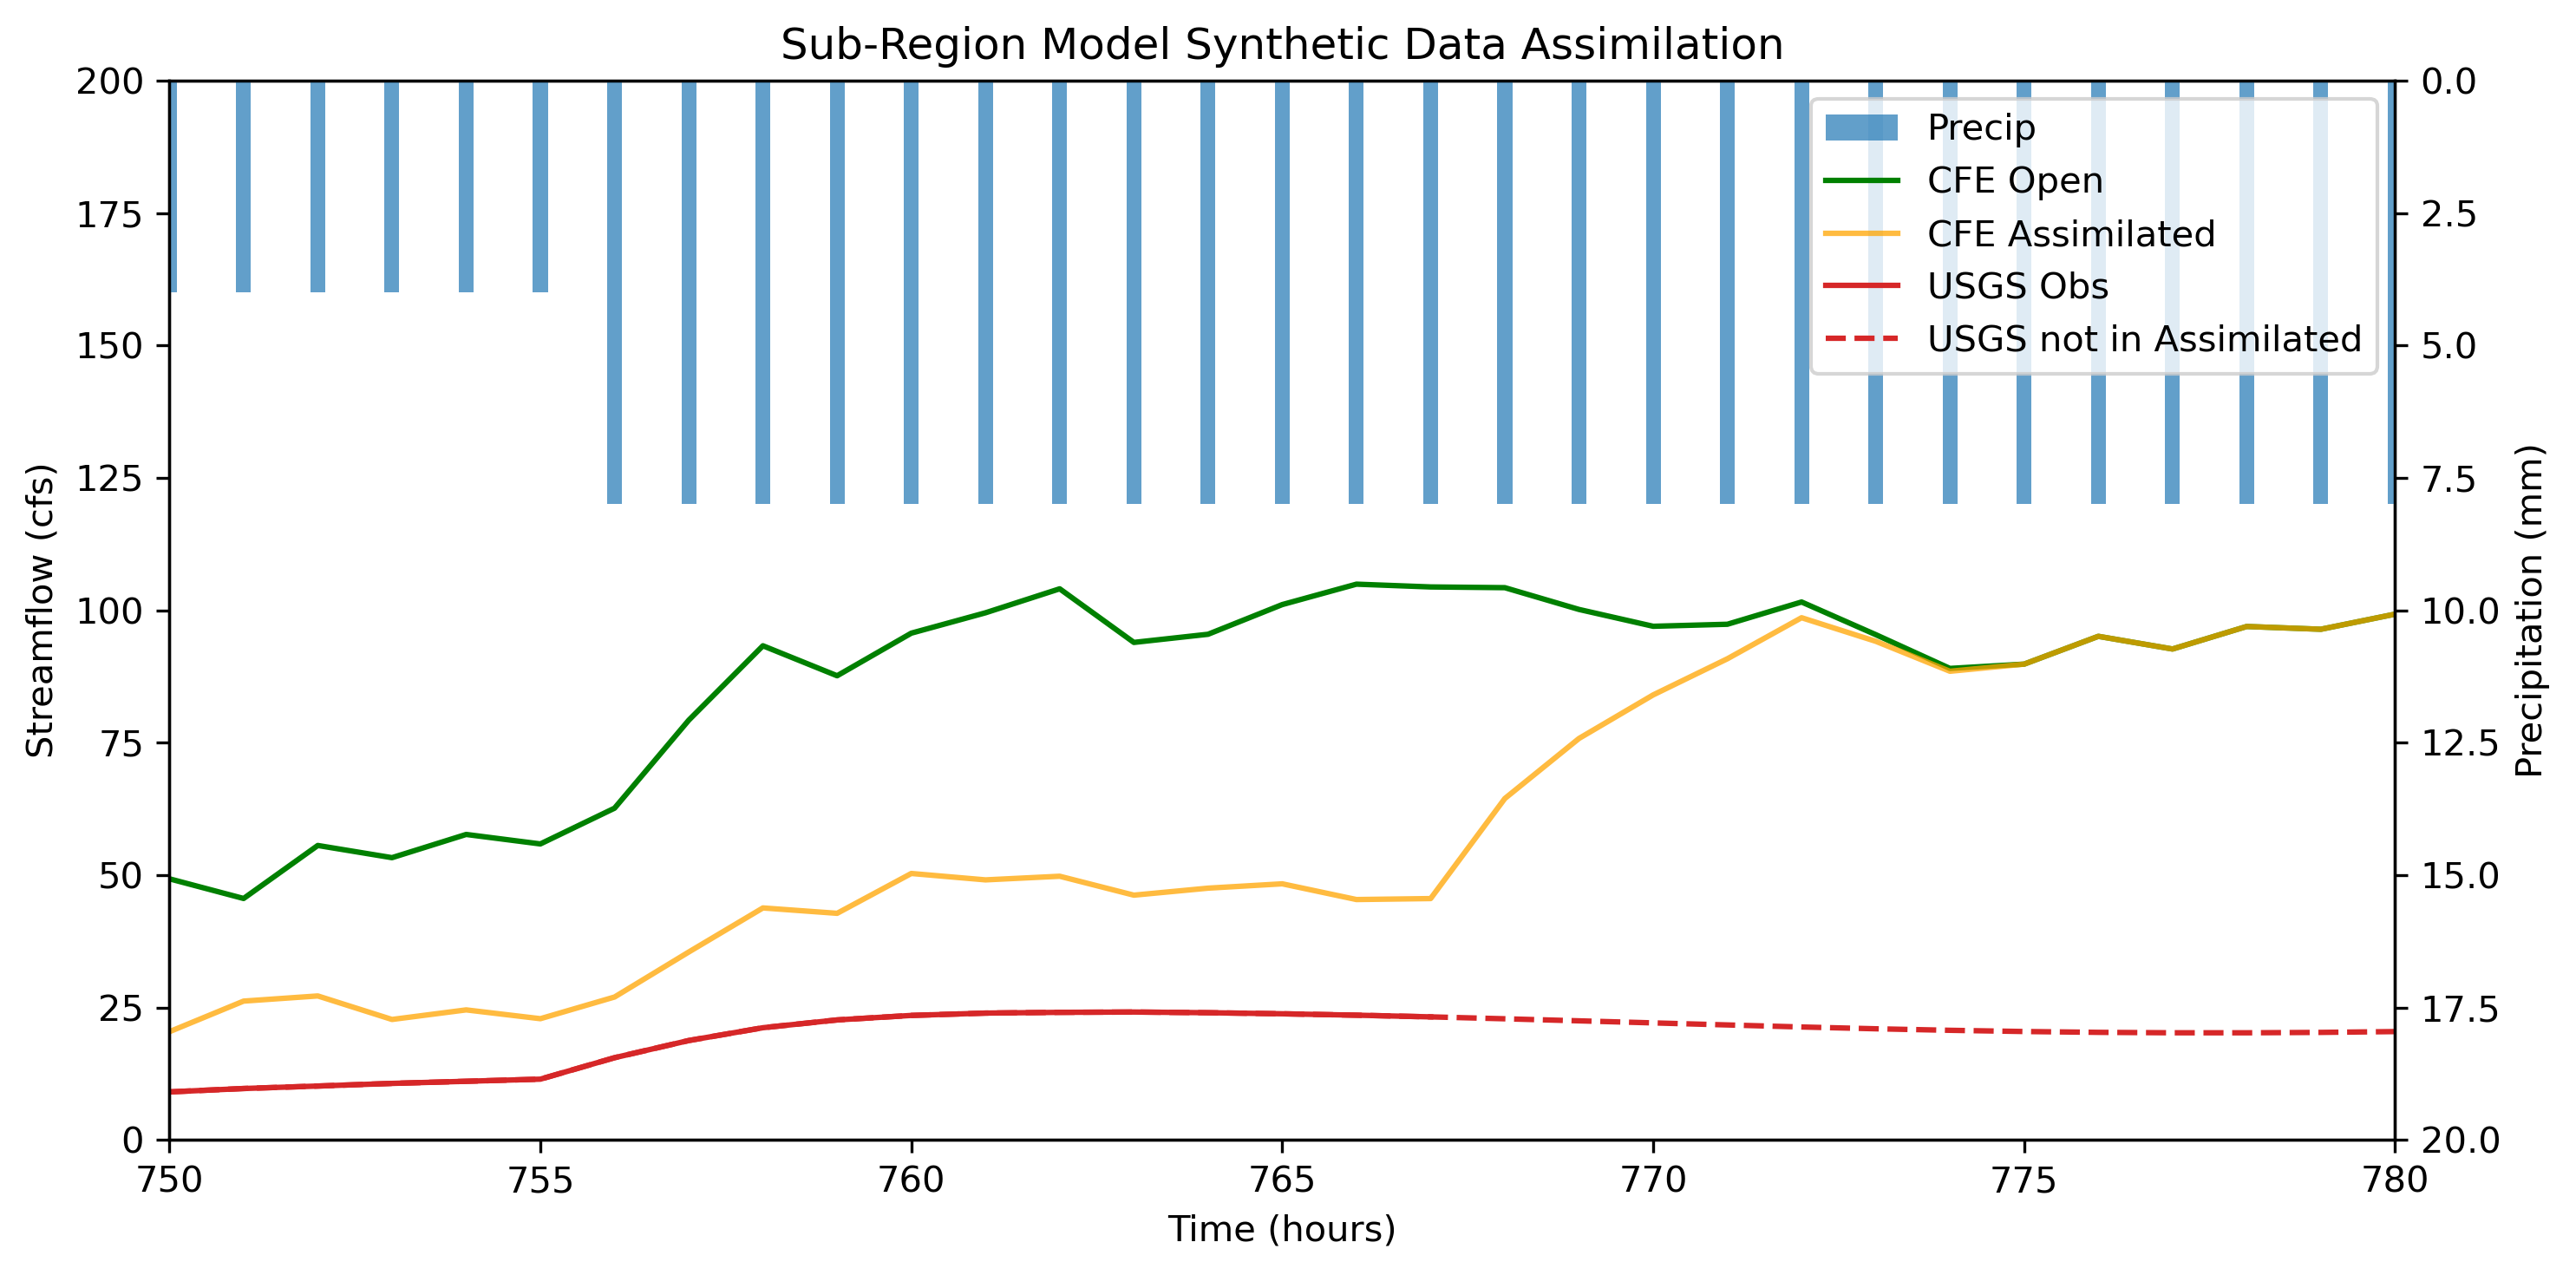

In [5]:
# Define time range for plotting
istart_plot=0
iend_plot=786
x = list(range(istart_plot, iend_plot))

# Set plotting dimensions
fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

# Make double y-axis to plot precipitation on top of of the plot. Set labels and limits for axes
ax2 = ax1.twinx()
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,20,1)
ax2.invert_yaxis()
plt.xlim(750,780)

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Streamflow (cfs)')
ax1.set_ylim(0,200,1)

plt.title('Sub-Region Model Synthetic Data Assimilation')

# Plot the variables on the plot! 
Precip = ax2.bar(x, df_forcing['APCP_surface_0'],width=0.2,alpha=0.7, color="tab:blue", label = 'Precip')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(OBSERVATIONS_LIST[istart_plot:768], color = 'tab:red', label = 'USGS Obs')
Obs2, = ax1.plot(OBSERVATIONS_LIST[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS not in Assimilated')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

# Plot the legend and fix layout
plt.legend(handles = [Precip,Open,Analysis,Obs,Obs2], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
fig.tight_layout()
ax1.margins(x=0)

#plt.savefig("WorkingDA_7-19.png")
plt.show()


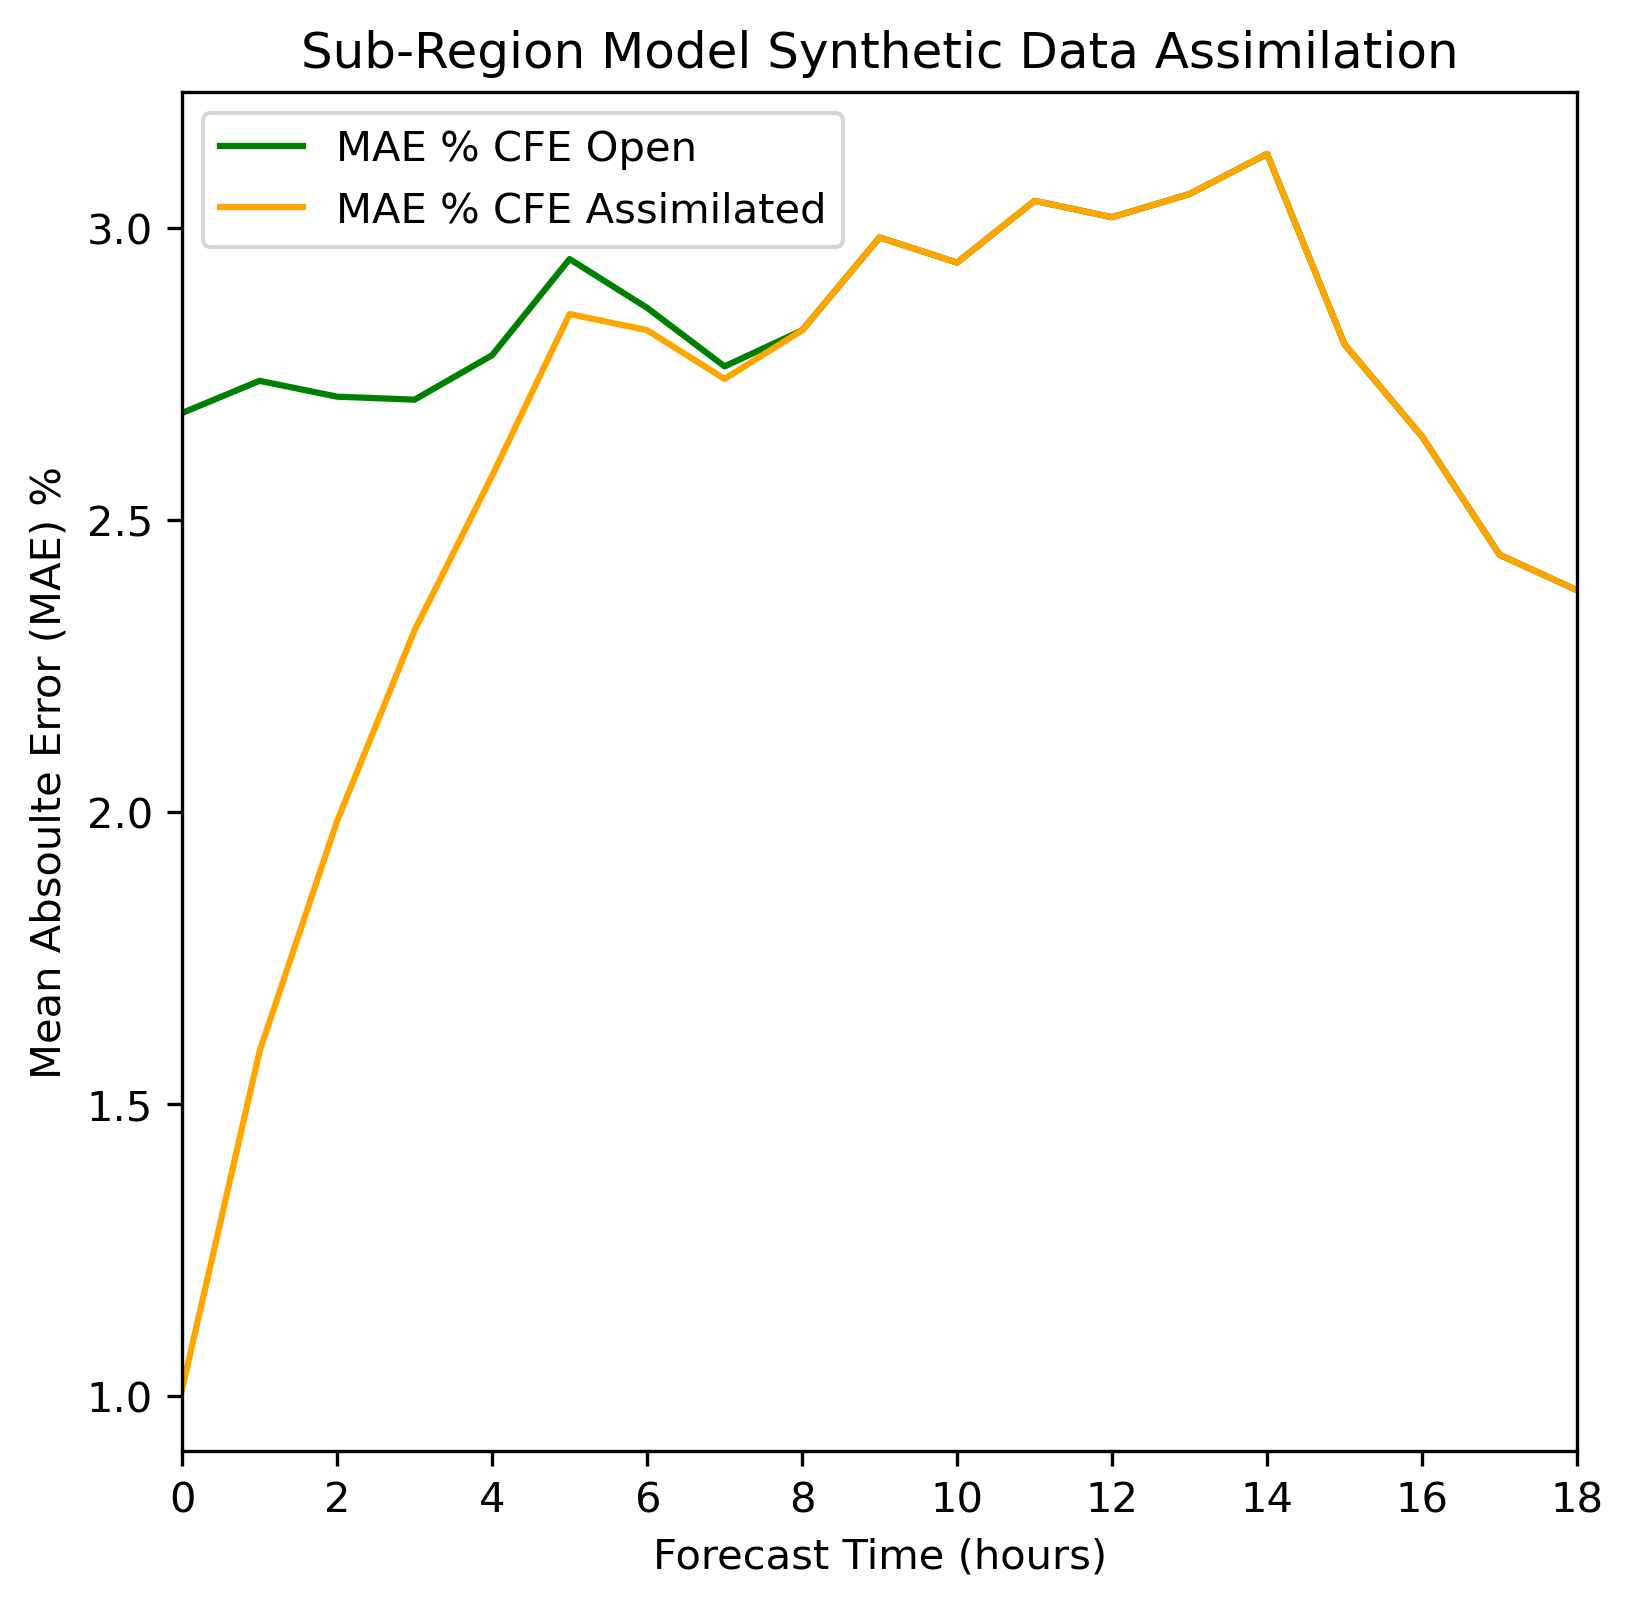

In [6]:
# Plot the Mean Absolute Error (MAE) of CFE Open vs CFE Assimilated
fig = plt.subplots(figsize = (6,6), dpi=300)

# Set labels and limits
plt.title('Sub-Region Model Synthetic Data Assimilation')
plt.xlim(0,18)
plt.xlabel('Forecast Time (hours)')
plt.ylabel('Mean Absoulte Error (MAE) %')

# Plot data
plt.plot(cfeOpen_ensa_mean, color = 'green', label = 'MAE % CFE Open')
plt.plot(cfeanalysis_ensa_mean, color = 'orange', label = 'MAE % CFE Assimilated')

# Show
plt.legend()
plt.show()


In [10]:
# Put values into dataframe to calculate statistics
df = pd.DataFrame({"obs":OBSERVATIONS_LIST,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True) #drop NaN values
df.reset_index(drop=True, inplace=True) #reset index


# CFE Open Evaluation
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias_open=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("CFE Open Statistics")
print("r_open     =",r_open[0])
print("KGE_open   =",kge_open[0])
print("NSE_open   =", nse_open[0])
print("PBIAS_open =", pbias_open[0])
print("--------------------------")

# CFE Analysis Evaluation
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("CFE Analysis Statistics")
print("r_analysis     =",r_analysis[0])
print("KGE_analysis   =",kge_analysis[0])
print("NSE_analysis   =", nse_analysis[0])
print("PBIAS_analysis =", pbias_analysis[0])
print("--------------------------")

# Mean and Std of Models and Observations
print("Mean and STD of Models and Observations")
print("mean_obs      =",np.mean(df["obs"]))
print("STD_obs       =",np.std(df["obs"]))
print("mean_open     =",np.mean(df["cfeOpen"]))
print("STD_open      =",np.std(df["cfeOpen"]))
print("mean_analysis =",np.mean(df["cfeAnalysis"]))
print("STD_analysis  =",np.std(df["cfeAnalysis"]))

CFE Open Statistics
r_open     = 0.9752711532378185
KGE_open   = -0.0767505289500583
NSE_open   = -0.8777810226868932
PBIAS_open = 84.00853906632571
--------------------------
CFE Analysis Statistics
r_analysis     = 0.9180462735166316
KGE_analysis   = 0.1794356589279832
NSE_analysis   = 0.19836474258494952
PBIAS_analysis = 66.00162536739361
--------------------------
Mean and STD of Models and Observations
mean_obs      = 7.82998928152997
STD_obs       = 11.330467618341043
mean_open     = 48.96356445483878
STD_open      = 34.65822995885161
mean_analysis = 23.030481210182817
STD_analysis  = 21.81503869578309
